In [1]:
import numpy as np

# Importing standard Qiskit libraries
from qiskit import QuantumCircuit, transpile, Aer, IBMQ
from qiskit.tools.jupyter import *
from qiskit.visualization import *
import time
from qiskit.providers.aer import QasmSimulator
import numpy as np
from qiskit_experiments.library import randomized_benchmarking as rb
#from qiskit_experiments.library import StandardRB, InterleavedRB
from qiskit_experiments.framework import ParallelExperiment, BatchExperiment
from qiskit_experiments.library.randomized_benchmarking import RBUtils
from qiskit_experiments.library import StandardRB, InterleavedRB
import qiskit.circuit.library as circuits
import qiskit.circuit.library
from qiskit.circuit import Delay, Instruction
from qiskit.circuit.library.standard_gates import CZGate, RXXGate, RZZGate, RZXGate, XGate, SXGate, IGate, CCXGate, SGate
from datetime import datetime


# For simulation
from qiskit.providers.aer import AerSimulator

In [2]:
from qiskit import IBMQ
#IBMQ.save_account('befca44219528a564b7f4d3f53707de8985c22fb7b8c969ef2728c830de7c612716e76f41fbc0a52d65f63e71a3a2437948befd3042b1ffab4ced07d573192f1')
IBMQ.load_account()
IBMQ.providers()

[<AccountProvider for IBMQ(hub='ibm-q', group='open', project='main')>,
 <AccountProvider for IBMQ(hub='ibm-q-community', group='qamp', project='spring-22-17')>,
 <AccountProvider for IBMQ(hub='ibm-q-community', group='qamp', project='spring-22-17-2')>,
 <AccountProvider for IBMQ(hub='ibm-q-skku', group='internal', project='reservations')>,
 <AccountProvider for IBMQ(hub='ibm-q-skku', group='skku', project='squirl')>,
 <AccountProvider for IBMQ(hub='ibm-q-skku', group='skku', project='skku-graduate')>,
 <AccountProvider for IBMQ(hub='qc-spring-22-4', group='group-4', project='recdZ7NwFc2tUZtMH')>]

In [3]:
provider=IBMQ.providers()[4]
#provider = IBMQ.get_provider(hub='ibm-q-community', group='qamp', project='spring-22-17')
#backend=provider.backend.ibmq_lima
backend = provider.get_backend('ibmq_brooklyn')

# get the basic feautures including qubit number of the backend.
config = backend.configuration()
backend_job_limit=backend.job_limit()

print("{0} is on version {1}. It has {2} qubit{3}. It "
      "{4} OpenPulse programs. The basis gates supported on this device are {5}.{6} are the list of connected qubits."
      "{7} can handle maximum {8} circuits(experiments) per job."
      "Maximum number of active job i can have on it (cocurrent jobs that a user is able to submit to a backend) is {9}."
      "".format(config.backend_name,
                config.backend_version,
                config.n_qubits,
                '' if config.n_qubits == 1 else 's',
                'supports' if config.open_pulse else 'does not support',
                config.basis_gates,
                config.coupling_map,
               config.backend_name,
               config.max_experiments,
               backend_job_limit.maximum_jobs))

ibmq_brooklyn is on version 1.5.10. It has 65 qubits. It does not support OpenPulse programs. The basis gates supported on this device are ['id', 'rz', 'sx', 'x', 'cx', 'reset'].[[0, 1], [0, 10], [1, 0], [1, 2], [2, 1], [2, 3], [3, 2], [3, 4], [4, 3], [4, 5], [4, 11], [5, 4], [5, 6], [6, 5], [6, 7], [7, 6], [7, 8], [8, 7], [8, 9], [8, 12], [9, 8], [10, 0], [10, 13], [11, 4], [11, 17], [12, 8], [12, 21], [13, 10], [13, 14], [14, 13], [14, 15], [15, 14], [15, 16], [15, 24], [16, 15], [16, 17], [17, 11], [17, 16], [17, 18], [18, 17], [18, 19], [19, 18], [19, 20], [19, 25], [20, 19], [20, 21], [21, 12], [21, 20], [21, 22], [22, 21], [22, 23], [23, 22], [23, 26], [24, 15], [24, 29], [25, 19], [25, 33], [26, 23], [26, 37], [27, 28], [27, 38], [28, 27], [28, 29], [29, 24], [29, 28], [29, 30], [30, 29], [30, 31], [31, 30], [31, 32], [31, 39], [32, 31], [32, 33], [33, 25], [33, 32], [33, 34], [34, 33], [34, 35], [35, 34], [35, 36], [35, 40], [36, 35], [36, 37], [37, 26], [37, 36], [38, 27], [38

# Comparing the error rate of CXGate and 2qDelay

ibmq_brooklyn
CZGate on q27,28
2022-05-28 22:27:21.085145


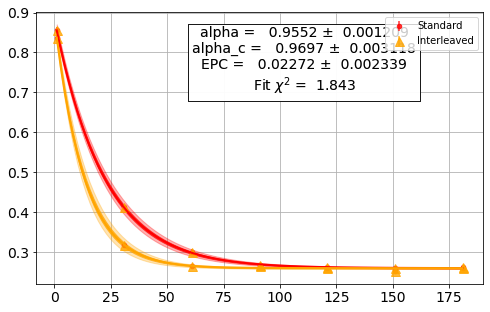

DbAnalysisResultV1
- name: @Parameters_InterleavedRBAnalysis
- value: [0.6237241222981386, 0.9552327575370061, 0.9697049795428274, 0.2594948699916121]
- χ²: 1.8433897752398232
- quality: good
- extra: <4 items>
- device_components: ['Q27', 'Q28']
- verified: False
DbAnalysisResultV1
- name: alpha
- value: 0.9552+/-0.0012
- χ²: 1.8433897752398232
- quality: good
- extra: <1 items>
- device_components: ['Q27', 'Q28']
- verified: False
DbAnalysisResultV1
- name: alpha_c
- value: 0.9697+/-0.0031
- χ²: 1.8433897752398232
- quality: good
- extra: <1 items>
- device_components: ['Q27', 'Q28']
- verified: False
DbAnalysisResultV1
- name: EPC
- value: 0.0227+/-0.0023
- χ²: 1.8433897752398232
- quality: good
- extra: <3 items>
- device_components: ['Q27', 'Q28']
- verified: False


In [11]:
# different calibration
lengths = np.arange(1, 200, 30)
num_samples = 10
seed = 1010
qubits = [27,28]
print(backend)
print('CZGate on q27,28')
print(datetime.today())

int_exp2 = InterleavedRB(
    circuits.CZGate(), qubits, lengths, num_samples=num_samples, seed=seed)

# Run
int_expdata2 = int_exp2.run(backend).block_for_results()
int_results2 = int_expdata2.analysis_results()
# View result data
display(int_expdata2.figure(0))
for result in int_results2:
    print(result)

ibmq_brooklyn
CXGate
2022-05-27 23:02:33.383849


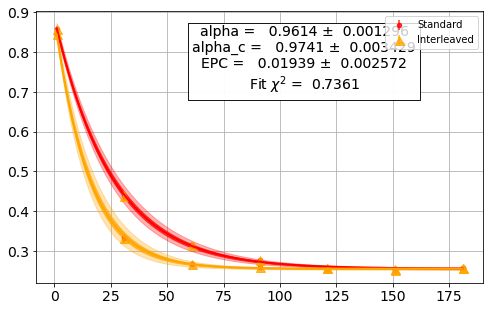

DbAnalysisResultV1
- name: @Parameters_InterleavedRBAnalysis
- value: [0.6285952225166036, 0.9613828915502808, 0.9741412217961292, 0.2555363627952024]
- χ²: 0.7361396315355352
- quality: good
- extra: <4 items>
- device_components: ['Q27', 'Q28']
- verified: False
DbAnalysisResultV1
- name: alpha
- value: 0.9614+/-0.0013
- χ²: 0.7361396315355352
- quality: good
- extra: <1 items>
- device_components: ['Q27', 'Q28']
- verified: False
DbAnalysisResultV1
- name: alpha_c
- value: 0.9741+/-0.0034
- χ²: 0.7361396315355352
- quality: good
- extra: <1 items>
- device_components: ['Q27', 'Q28']
- verified: False
DbAnalysisResultV1
- name: EPC
- value: 0.0194+/-0.0026
- χ²: 0.7361396315355352
- quality: good
- extra: <3 items>
- device_components: ['Q27', 'Q28']
- verified: False


In [4]:
lengths = np.arange(1, 200, 30)
num_samples = 10
seed = 1010
qubits = [27,28]
print(backend)
print('CXGate')
print(datetime.today())

int_exp2 = InterleavedRB(
    circuits.CXGate(), qubits, lengths, num_samples=num_samples, seed=seed)

# Run
int_expdata2 = int_exp2.run(backend).block_for_results()
int_results2 = int_expdata2.analysis_results()
# View result data
display(int_expdata2.figure(0))
for result in int_results2:
    print(result)

In [5]:
backend.properties().gate_length('cx',(0,1))/backend.configuration().dt

1791.9999999999998

ibmq_brooklyn
2q Delay
2022-05-28 10:41:21.027531
1376.0


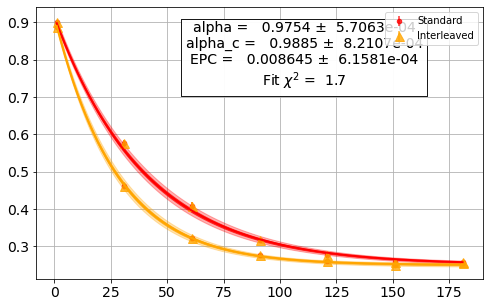

DbAnalysisResultV1
- name: @Parameters_InterleavedRBAnalysis
- value: [0.6644989399897381, 0.9753825160100987, 0.9884739146860715, 0.2497643156997106]
- χ²: 1.6997120191074333
- quality: good
- extra: <4 items>
- device_components: ['Q0', 'Q1']
- verified: False
DbAnalysisResultV1
- name: alpha
- value: 0.9754+/-0.0006
- χ²: 1.6997120191074333
- quality: good
- extra: <1 items>
- device_components: ['Q0', 'Q1']
- verified: False
DbAnalysisResultV1
- name: alpha_c
- value: 0.9885+/-0.0008
- χ²: 1.6997120191074333
- quality: good
- extra: <1 items>
- device_components: ['Q0', 'Q1']
- verified: False
DbAnalysisResultV1
- name: EPC
- value: 0.0086+/-0.0006
- χ²: 1.6997120191074333
- quality: good
- extra: <3 items>
- device_components: ['Q0', 'Q1']
- verified: False


In [6]:
lengths = np.arange(1, 200, 30)
num_samples = 10
seed = 1010
qubits = [0,1]
print(backend)
print('2q Delay')
print(datetime.today())

duration=backend.properties().gate_length('cx',(27,28))/backend.configuration().dt
print(duration)
delay_qc = QuantumCircuit(2)
delay_qc.delay(round(duration), [0], unit="dt")
delay_qc.delay(round(duration), [1], unit="dt")
int_exp2 = InterleavedRB(
    interleaved_element=delay_qc, qubits=[0,1], lengths=lengths, num_samples=num_samples, seed=seed)
int_exp2.set_transpile_options(scheduling_method='asap')
# Run
int_expdata2 = int_exp2.run(backend, shots=1000).block_for_results()
int_results2 = int_expdata2.analysis_results()
# View result data
display(int_expdata2.figure(0))
for result in int_results2:
    print(result)

ibmq_brooklyn
CXGate
2022-05-28 11:12:49.525753


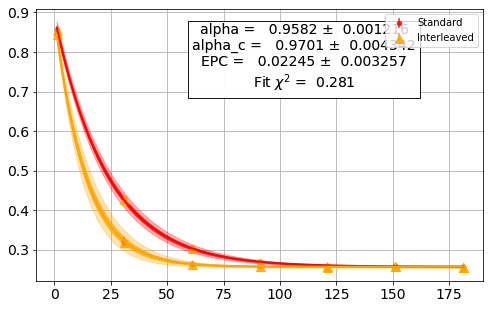

DbAnalysisResultV1
- name: @Parameters_InterleavedRBAnalysis
- value: [0.6311403718237742, 0.9581608813880367, 0.9700728020617636, 0.2568008567087677]
- χ²: 0.281011634982113
- quality: good
- extra: <4 items>
- device_components: ['Q27', 'Q28']
- verified: False
DbAnalysisResultV1
- name: alpha
- value: 0.9582+/-0.0012
- χ²: 0.281011634982113
- quality: good
- extra: <1 items>
- device_components: ['Q27', 'Q28']
- verified: False
DbAnalysisResultV1
- name: alpha_c
- value: 0.970+/-0.004
- χ²: 0.281011634982113
- quality: good
- extra: <1 items>
- device_components: ['Q27', 'Q28']
- verified: False
DbAnalysisResultV1
- name: EPC
- value: 0.0224+/-0.0033
- χ²: 0.281011634982113
- quality: good
- extra: <3 items>
- device_components: ['Q27', 'Q28']
- verified: False


In [7]:
lengths = np.arange(1, 200, 30)
num_samples = 10
seed = 1010
qubits = [27,28]
print(backend)
print('CXGate')
print(datetime.today())

# Run an Interleaved RB experiment on qubits 0, 1
# The interleaved gate is the cx gate
int_exp2 = InterleavedRB(
    circuits.CXGate(), qubits, lengths, num_samples=num_samples, seed=seed)

# Run
int_expdata2 = int_exp2.run(backend).block_for_results()
int_results2 = int_expdata2.analysis_results()
# View result data
display(int_expdata2.figure(0))
for result in int_results2:
    print(result)

In [6]:
backend.properties(datetime=datetime(2022,5,28,13)).gate_error('cx',(0,1))

0.00998947746452114

In [7]:
date=datetime(2022,5,28,13)
CLE=RBUtils.coherence_limit(nQ=2, 
T1_list=[backend.properties(datetime=date).t1(27),backend.properties(datetime=date).t1(28)],
T2_list=[backend.properties(datetime=date).t2(27),backend.properties(datetime=date).t2(28)], 
gatelen=backend.properties(datetime=date).gate_length('cx',(27,28)))
print(f"CLE is  {CLE} at {date}")

CLE is  0.01487239248276015 at 2022-05-28 13:00:00


ibmq_brooklyn
2q Delay
2022-05-28 13:01:22.015435
1376.0


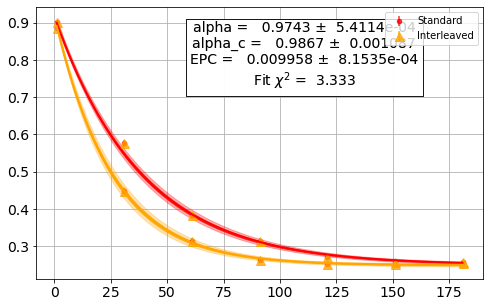

DbAnalysisResultV1
- name: @Parameters_InterleavedRBAnalysis
- value: [0.6671286214805972, 0.974262892721414, 0.9867227842730629, 0.24946080824758055]
- χ²: 3.333296831677734
- quality: bad
- extra: <4 items>
- device_components: ['Q0', 'Q1']
- verified: False
DbAnalysisResultV1
- name: alpha
- value: 0.9743+/-0.0005
- χ²: 3.333296831677734
- quality: bad
- extra: <1 items>
- device_components: ['Q0', 'Q1']
- verified: False
DbAnalysisResultV1
- name: alpha_c
- value: 0.9867+/-0.0011
- χ²: 3.333296831677734
- quality: bad
- extra: <1 items>
- device_components: ['Q0', 'Q1']
- verified: False
DbAnalysisResultV1
- name: EPC
- value: 0.0100+/-0.0008
- χ²: 3.333296831677734
- quality: bad
- extra: <3 items>
- device_components: ['Q0', 'Q1']
- verified: False


In [8]:
lengths = np.arange(1, 200, 30)
num_samples = 10
seed = 1010
qubits = [0,1]
print(backend)
print('2q Delay')
print(datetime.today())

duration=backend.properties().gate_length('cx',(27,28))/backend.configuration().dt
print(duration)
delay_qc = QuantumCircuit(2)
delay_qc.delay(round(duration), [0], unit="dt")
delay_qc.delay(round(duration), [1], unit="dt")
int_exp2 = InterleavedRB(
    interleaved_element=delay_qc, qubits=[27,28], lengths=lengths, num_samples=num_samples, seed=seed)
int_exp2.set_transpile_options(scheduling_method='asap')
# Run
int_expdata2 = int_exp2.run(backend, shots=1000).block_for_results()
int_results2 = int_expdata2.analysis_results()
# View result data
display(int_expdata2.figure(0))
for result in int_results2:
    print(result)